# Amazon Top 50 Bestselling Books 2009 - 2019
Kaggle : https://www.kaggle.com/sootersaalu/amazon-top-50-bestselling-books-2009-2019/metadata

1. Data cleansing
2. EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('./data/Amazon-Top-50-Bestselling/data.csv')
print(df.shape)
df.head()

(550, 7)


,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


## 1. Data cleansing

### Cleansing "Author" column
- There exists duplicate author name (e.g., J.K. Rowling, J. K. Rowling)  

In [3]:
df["Author"] = df["Author"].str.replace(' ','')
df["Author"]

0                     JJSmith
1                 StephenKing
2            JordanB.Peterson
3                GeorgeOrwell
4      NationalGeographicKids
                ...          
545                JeffKinney
546                JenSincero
547                JenSincero
548                JenSincero
549                JenSincero
Name: Author, Length: 550, dtype: object

## Delete duplicated "Name"
- There exist duplication in "Name" column
- For example, "Wonder" exists during 5 years

In [4]:
df.loc[df["Name"] == "Wonder"]

,Name,Author,User Rating,Reviews,Price,Year,Genre
540,Wonder,R.J.Palacio,4.8,21625,9,2013,Fiction
541,Wonder,R.J.Palacio,4.8,21625,9,2014,Fiction
542,Wonder,R.J.Palacio,4.8,21625,9,2015,Fiction
543,Wonder,R.J.Palacio,4.8,21625,9,2016,Fiction
544,Wonder,R.J.Palacio,4.8,21625,9,2017,Fiction


In [5]:
# Delete duplication
df = df.drop_duplicates(subset=["Name"])
df.loc[df["Name"] == "Wonder"]

,Name,Author,User Rating,Reviews,Price,Year,Genre
540,Wonder,R.J.Palacio,4.8,21625,9,2013,Fiction


## 2. EDA

We will make a new feature "Weighted Rating".  
- It gives a weight to book's rate(R) when there exist enough reviews.  
- When there is not enough reviews, it gives a weight to average rate(C) rather than book's rate(R).


Weighted rating : 
$$
WeightedRating(WR) = \frac{v}{v+m}R + \frac{m}{v+m}C
$$
where   
- R = average rate for the book  
- C = the mean rate across the whole data  
- v = number of reviews for the book  
- m = minimum reviews required to be listed in the best seller list  



In [6]:
def get_weighted_rate(dataframe):
    R = np.array(dataframe["User Rating"])
    C = np.mean(R)
    v = np.array(dataframe["Reviews"])
    m = np.min(v)

    return (v*R)/(v+m) + (m*C)/(v+m)

To consider about genre, split data based on genre

In [7]:
fiction_books = df.loc[df["Genre"] == "Fiction"]
non_fiction_books = df.loc[df["Genre"] == "Non Fiction"]

In [8]:
df["Weighted Rating"] = get_weighted_rate(df)
fiction_books["Weighted Rating"] = get_weighted_rate(fiction_books)
non_fiction_books["Weighted Rating"] = get_weighted_rate(non_fiction_books)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Distribution of genre visualization

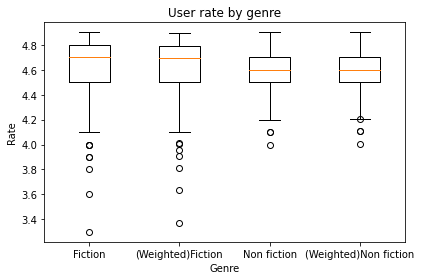

In [9]:
plt.boxplot(
    x=[fiction_books["User Rating"], fiction_books["Weighted Rating"], non_fiction_books["User Rating"], non_fiction_books["Weighted Rating"]],
    labels=["Fiction", "(Weighted)Fiction", "Non fiction", "(Weighted)Non fiction"]
);

plt.title("User rate by genre")
plt.xlabel("Genre")
plt.ylabel("Rate")
plt.tight_layout()

Standard deviation of fiction's review is larger than non fiction's one

In [10]:
print(fiction_books["Reviews"].std())
print(non_fiction_books["Reviews"].std())

13312.234067321988
7241.629308503344


## Rate of genres by year visualization

In [11]:
fiction_rate_by_year = fiction_books.groupby("Year")["User Rating"].mean()
fiction_weighted_rate_by_year = fiction_books.groupby("Year")["Weighted Rating"].mean()

non_fiction_rate_by_year = non_fiction_books.groupby("Year")["User Rating"].mean()
non_fiction_weighted_rate_by_year = non_fiction_books.groupby("Year")["Weighted Rating"].mean()

df_rate_by_year = df.groupby("Year")["User Rating"].mean()
df_weighted_rate_by_year = df.groupby("Year")["Weighted Rating"].mean()

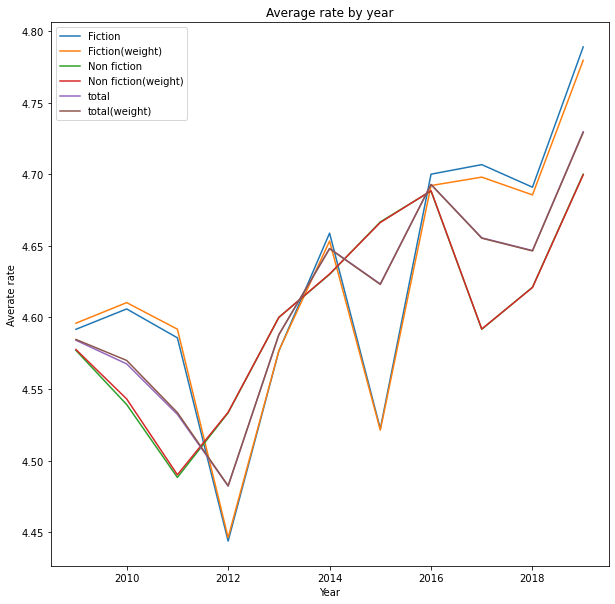

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(fiction_rate_by_year, label="Fiction")
plt.plot(fiction_weighted_rate_by_year, label="Fiction(weight)")

plt.plot(non_fiction_rate_by_year, label="Non fiction")
plt.plot(non_fiction_weighted_rate_by_year, label="Non fiction(weight)")

plt.plot(df_rate_by_year, label="total")
plt.plot(df_weighted_rate_by_year, label="total(weight)")

plt.title("Average rate by year")
plt.xlabel("Year")
plt.ylabel("Averate rate")
plt.legend(loc="upper left")


# High rated book authors

- Only consider authors who have published more than 2 books

In [13]:
# Filter out authors who only published 1 book.
books_per_fiction_author = fiction_books.groupby("Author").count()
books_per_non_fiction_author = non_fiction_books.groupby("Author").count()

at_least_two_fiction = books_per_fiction_author.loc[books_per_fiction_author["Name"] > 1]
at_least_two_non_fiction = books_per_non_fiction_author.loc[books_per_non_fiction_author["Name"] > 1]

authors_at_least_two_fiction_books = fiction_books.loc[fiction_books["Author"].isin(at_least_two_fiction.index)]
authors_at_least_two_non_fiction_books = non_fiction_books.loc[non_fiction_books["Author"].isin(at_least_two_non_fiction.index)]

In [14]:
high_rate_fiction_author = authors_at_least_two_fiction_books.groupby("Author")[["User Rating", "Weighted Rating", "Reviews"]].mean()
high_rate_non_fiction_author = authors_at_least_two_non_fiction_books.groupby("Author")[["User Rating", "Weighted Rating", "Reviews"]].mean()

high_rate_fiction_author = high_rate_fiction_author.sort_values(by=["Weighted Rating"])
high_rate_non_fiction_author = high_rate_non_fiction_author.sort_values(by=["Weighted Rating"])

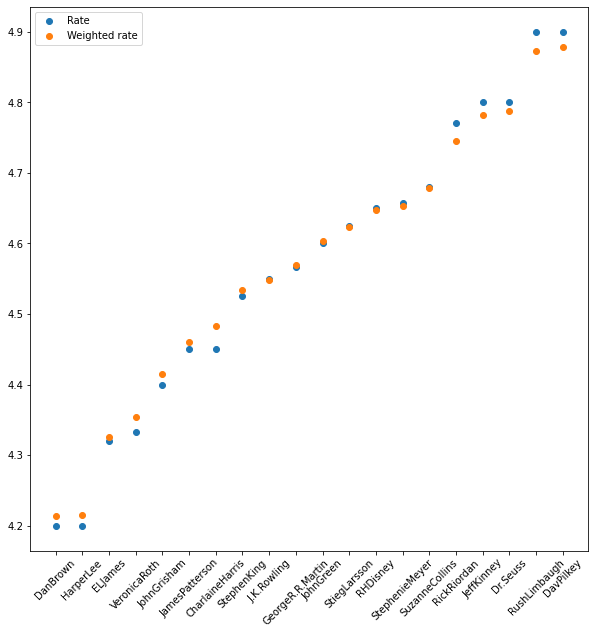

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(high_rate_fiction_author.index, high_rate_fiction_author["User Rating"], label="Rate")
plt.scatter(high_rate_fiction_author.index, high_rate_fiction_author["Weighted Rating"], label="Weighted rate")

plt.xticks(rotation=45);
plt.legend(loc="upper left")

In fiction books, there is tendency that high rated books have the lower number of reviews than others.  


In [16]:
high_rate_fiction_author.loc[high_rate_fiction_author.index.isin(["DavPilkey", "DanBrown"])]

,User Rating,Weighted Rating,Reviews
Author,,,
DanBrown,4.2,4.214251,19100.666667
DavPilkey,4.9,4.878180,7376.833333


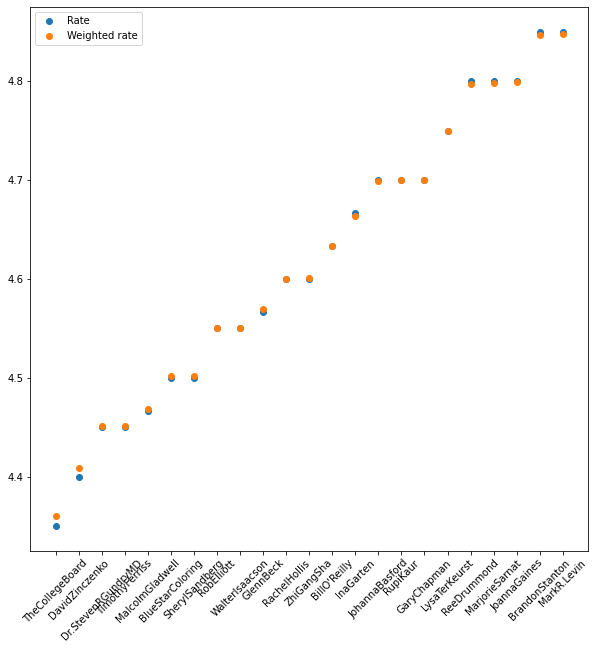

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(high_rate_non_fiction_author.index, high_rate_non_fiction_author["User Rating"], label="Rate")
plt.scatter(high_rate_non_fiction_author.index, high_rate_non_fiction_author["Weighted Rating"], label="Weighted rate")

plt.xticks(rotation=45);
plt.legend(loc="upper left")

In [18]:
high_rate_non_fiction_author.loc[high_rate_non_fiction_author.index.isin(["TheCollegeBoard", "MarkR.Levin"])]

,User Rating,Weighted Rating,Reviews
Author,,,
TheCollegeBoard,4.35,4.359680,1004.0
MarkR.Levin,4.85,4.848141,4892.0
